In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import math
from math import ceil, floor
from PIL import Image
import cv2
import torch
import os
import torch.optim as optim
from torch.nn import CTCLoss
import matplotlib.pyplot as plt
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files unde

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!python --version
!pip freeze | grep torch

Python 3.7.10
pytorch-ignite==0.4.7
pytorch-lightning==1.4.4
torch @ file:///tmp/torch/torch-1.9.1-cp37-cp37m-linux_x86_64.whl
torchaudio @ file:///tmp/torch/torchaudio-0.9.1-cp37-cp37m-linux_x86_64.whl
torchmetrics==0.5.0
torchtext @ file:///tmp/torch/torchtext-0.10.1-cp37-cp37m-linux_x86_64.whl
torchvision @ file:///tmp/torch/torchvision-0.10.1-cp37-cp37m-linux_x86_64.whl


# First step: Loading data

## 1.1 Dataset

In [3]:
# class Dataset(torch.utils.data.Dataset):
    
#     CHARS = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
#     CHAR2LABEL = {char: i + 1 for i, char in enumerate(CHARS)}
#     LABEL2CHAR = {label:char for char,label in CHAR2LABEL.items()}
    
#     def __init__(self, csv_file, mode='train', transform=None):
        
#         self.mode = mode # 'train', 'val' or 'test'
#         self.data_list = []
#         self.coordinate = []
#         self.text = []
#         self.transform = transform
              
#         with open(csv_file, newline='') as csvfile:
#             reader = csv.DictReader(csvfile) 
#             for row in reader:
#                 self.data_list.append(row['new_filename']+'.jpg') 
#                 if mode == 'train':
#                     self.coordinate.append([float(row['top.left.x']),float(row['top.left.y']),float(row['bottom.right.x']),float(row['bottom.right.y'])])
#                 if mode != 'train':
#                     self.coordinate.append([float(row['tlx']),float(row['tly']),float(row['brx']),float(row['bry'])])
#                 if mode != 'test':
#                     self.text.append(row['label'])
                    
#     def __getitem__(self, index):
        
#         if self.mode == 'train':
#             data = Image.open('../input/nstuocr/public/train/'+ self.data_list[index])
#             data = data.crop((self.coordinate[index]))
#             if self.transform is not None:
#                 data = self.transform(data)
                
#         if self.mode == 'valid':
#             data = Image.open('../input/nstuocr/public/test/'+ self.data_list[index])
#             data = data.crop((self.coordinate[index]))
#             if self.transform is not None:
#                 data = self.transform(data)
                
#         if self.mode == 'test':
#             data = Image.open('../input/nstuocr/private/private/'+ self.data_list[index])
#             data = data.crop((self.coordinate[index]))
#             if self.transform is not None:
#                 data = self.transform(data)
#                 data = data[None, :]
#             return data
#         text = self.text[index]
#         target = [self.CHAR2LABEL[i] for i in text]
#         target_length = [len(target)]
        
#         target = torch.LongTensor(target)
#         target_length = torch.LongTensor(target_length)
            
#         return data, target, target_length

#     def __len__(self):
#         return len(self.data_list)

In [4]:
class Dataset(torch.utils.data.Dataset):
    
    CHARS = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    CHAR2LABEL = {char: i + 1 for i, char in enumerate(CHARS)}
    LABEL2CHAR = {label:char for char,label in CHAR2LABEL.items()}
    
    def __init__(self, csv_file, mode='train', transform=None):
        
        self.mode = mode # 'train', 'val' or 'test'
        self.data_list = []
        self.coordinate = []
        self.text = []
        self.angle = []
        self.transform = transform
              
        with open(csv_file, newline='') as csvfile:
            reader = csv.DictReader(csvfile) 
            
            ########################################################################################################
            temp = 0
            ########################################################################################################
            
            for row in reader:
            ########################################################################################################
                temp += 1
                if(temp == 32*3):
                    break
            ########################################################################################################
                self.data_list.append(row['new_filename']+'.jpg') 
                self.angle.append(float(row['angle']))
                self.coordinate.append([
                        [ ceil(float(row['trx'])),floor(float(row['try']))],
                        [ ceil(float(row['brx'])), ceil(float(row['bry']))],
                        [floor(float(row['blx'])), ceil(float(row['bly']))],
                        [floor(float(row['tlx'])),floor(float(row['tly']))]
                    ])

                if mode != 'test':
                    self.text.append(row['label'])
                    
    def __getitem__(self, index):
        
        # image path
        if self.mode == 'train':
            img_path = '../input/nstuocr/public/train/'   + self.data_list[index]
        if self.mode == 'valid':
            img_path = '../input/nstuocr/public/test/'    + self.data_list[index]
        if self.mode == 'test':
            img_path = '../input/nstuocr/private/private/'+ self.data_list[index]
            
        # image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # rotation
        ang = float(self.angle[index])
        (h, w) = img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2,h/2), -ang, 1)
        img = cv2.warpAffine(img, M, (w, h))
        
        # crop image
        pts1 = np.array(self.coordinate[index])
        pts = []
        for (a,b) in pts1:
            if a < 0:
                a = 0
            if b < 0:
                b = 0
            pts.append([a,b])
        pts = np.array(pts)
        height = img.shape[0]
        width = img.shape[1]
        mask = 255*np.ones((height, width), dtype=np.uint8)
        cv2.fillPoly(mask, np.int32([pts]), (150))
        res = cv2.bitwise_and(img, img, mask = mask)
        rect = cv2.boundingRect(pts) # returns (x,y,w,h) of the rect
        cropped = res[rect[1]: rect[1] + rect[3], rect[0]: rect[0] + rect[2]]

        # denoise、二值化 preprocess
        kernel = np.ones((3,3), np.uint8)
        img = cv2.GaussianBlur(cropped, (5, 5), 0) 
        img = cv2.fastNlMeansDenoising(img, templateWindowSize=11, searchWindowSize=21, h=20)
        img = cv2.dilate(img, kernel, iterations = 3)
        img = cv2.erode(img, kernel, iterations = 3)
        if(np.mean(img) > 70 and np.mean(img) < 100):
            img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
                                        cv2.THRESH_BINARY, 11, -0.05)
            img = cv2.fastNlMeansDenoising(img, templateWindowSize=11, searchWindowSize=100, h=50)
        elif (np.mean(img) > 120):
            img = cv2.erode(img, kernel, iterations = 1)
            img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
                                        cv2.THRESH_BINARY, 11, -0.01)
        else:
            img = img
        img = cv2.erode(img, kernel, iterations = 1)
        img = cv2.dilate(img, kernel, iterations = 1)
        img = cv2.erode(img, kernel, iterations = 1)
        img = cv2.dilate(img, kernel, iterations = 1)

        # change to PIL
        data = Image.fromarray(img)
        
        if self.mode != 'test':
            if self.transform is not None:
                data = self.transform(data)
        else:
            if self.transform is not None:
                data = self.transform(data)
                data = data[None, :]
            return data
        
        text = self.text[index]
        target = [self.CHAR2LABEL[i] for i in text]
        target_length = [len(target)]
        
        target = torch.LongTensor(target)
        target_length = torch.LongTensor(target_length)
            
        return data, target, target_length

    def __len__(self):
        return len(self.data_list)

In [5]:
from torchvision import transforms

transforms_train = transforms.Compose([
transforms.Resize((64, 300)),         
#transforms.RandomCrop((224, 224)),      #將照片隨機裁減為224x224的大小
#transforms.RandomHorizontalFlip(p=0.5), #0.5的機率是否水平翻轉
#transforms.RandomVerticalFlip(p=0.5),   #0.5的機率是否垂直翻轉
#transforms.RandomRotation(degrees=(-90, 90)),  #隨機地在-90~90度間旋轉
transforms.ToTensor(),  #將照片轉成tensor 並且將數值都轉換成0~1 
#transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transforms_test = transforms.Compose([
transforms.Resize((64, 300)),
#transforms.CenterCrop((224, 224)),
transforms.ToTensor(),
#transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [6]:
dataset_train = Dataset('../input/nstuocr/public_training_data_new2.csv', mode='train',transform=transforms_train)
dataset_val = Dataset('../input/nstuocr/public_testing_data_new2.csv', mode='valid', transform=transforms_train)
dataset_test = Dataset('../input/nstuocr/private_data_new2.csv', mode='test', transform=transforms_train)

In [7]:
print(dataset_train.__getitem__(0))
dataset_train.text[0]

(tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000]]]), tensor([ 4, 22, 24, 10, 10,  7,  1,  2,  3, 16]), tensor([10]))


'3LN996012F'

In [8]:
print("The first image's shape in dataset_train :", dataset_train.__getitem__(0)[0].size()) #[0]means data
print("There are", dataset_train.__len__(), "images in dataset_train.")
print('-'*50)

print("The first image's shape in dataset_val :", dataset_val.__getitem__(0)[0].size()) #[0]means data
print("There are", dataset_val.__len__(), "images in dataset_val.")
print('-'*50)

print("The first image's shape in dataset_test :", dataset_test.__getitem__(0)[0].size()) #[0]means data
print("There are", dataset_test.__len__(), "images in dataset_test.")

The first image's shape in dataset_train : torch.Size([1, 64, 300])
There are 95 images in dataset_train.
--------------------------------------------------
The first image's shape in dataset_val : torch.Size([1, 64, 300])
There are 95 images in dataset_val.
--------------------------------------------------
The first image's shape in dataset_test : torch.Size([1, 64, 300])
There are 95 images in dataset_test.


In [9]:
# check data 

data, label, label_length = dataset_train.__getitem__(0)
print('Answer:',dataset_train.text[0])
print('label(encoding):',label)
print('label length:',label_length.item())
print('data dimension:',data.size())

Answer: 3LN996012F
label(encoding): tensor([ 4, 22, 24, 10, 10,  7,  1,  2,  3, 16])
label length: 10
data dimension: torch.Size([1, 64, 300])


Label =  3LN996012F


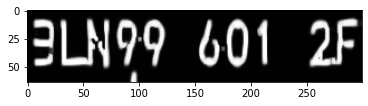

In [10]:
def imshow(tensor, title=None):
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image, 'gray')

imshow(dataset_train.__getitem__(0)[0]) #train
# data = Image.open('../input/nstuocr/public/train/public_train_7645.jpg')
# data = data.crop((370.62106,418.18262,707.5107,455.8296))
print('Label = ',dataset_train.text[0])
# display(data)

Label =  1W3624022A


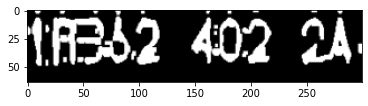

In [11]:
imshow(dataset_val.__getitem__(0)[0]) #valid
# data = Image.open('../input/nstuocr/public/test/public_test_419.jpg')
# data = data.crop((450.519104,433.1921692,792.390625,476.0797729))
print('Label = ',dataset_val.text[0])
# data

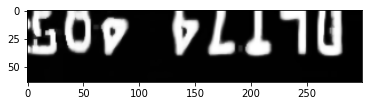

In [12]:
imshow(dataset_test.__getitem__(0)[0]) #test
# data = Image.open('../input/nstuocr/private/private/private_3761.jpg')
# data = data.crop((486.6741943,475.1752625,742.5422974,
# 513.0866699))
# data

## 1.2 Dataloader

In [13]:
from torch.utils.data import DataLoader

def collate_fn_steel(batch):
    images, targets, target_lengths = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.cat(targets, 0)
    target_lengths = torch.cat(target_lengths, 0)
    return images, targets, target_lengths

train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True,collate_fn=collate_fn_steel)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False,collate_fn=collate_fn_steel)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

# Second step: Buil up CRNN model

## 2.1 Build up nn model

In [14]:
import torch.nn as nn


class CRNN(nn.Module):

    def __init__(self, img_channel, img_height, img_width, num_class,
                 map_to_seq_hidden=64, rnn_hidden=256, leaky_relu=False):
        super(CRNN, self).__init__()

        self.cnn, (output_channel, output_height, output_width) = \
            self._cnn_backbone(img_channel, img_height, img_width, leaky_relu)

        self.map_to_seq = nn.Linear(output_channel * output_height, map_to_seq_hidden)

        self.rnn1 = nn.LSTM(map_to_seq_hidden, rnn_hidden, bidirectional=True)
        self.rnn2 = nn.LSTM(2 * rnn_hidden, rnn_hidden, bidirectional=True)

        self.dense = nn.Linear(2 * rnn_hidden, num_class)

    def _cnn_backbone(self, img_channel, img_height, img_width, leaky_relu):
        assert img_height % 16 == 0
        assert img_width % 4 == 0

        channels = [img_channel, 64, 128, 256, 256, 512, 512, 512]
        kernel_sizes = [3, 3, 3, 3, 3, 3, 2]
        strides = [1, 1, 1, 1, 1, 1, 1]
        paddings = [1, 1, 1, 1, 1, 1, 0]

        cnn = nn.Sequential()

        def conv_relu(i, batch_norm=False):
            # shape of input: (batch, input_channel, height, width)
            input_channel = channels[i]
            output_channel = channels[i+1]

            cnn.add_module(
                f'conv{i}',
                nn.Conv2d(input_channel, output_channel, kernel_sizes[i], strides[i], paddings[i])
            )

            if batch_norm:
                cnn.add_module(f'batchnorm{i}', nn.BatchNorm2d(output_channel))

            relu = nn.LeakyReLU(0.2, inplace=True) if leaky_relu else nn.ReLU(inplace=True)
            cnn.add_module(f'relu{i}', relu)

        # size of image: (channel, height, width) = (img_channel, img_height, img_width)
        conv_relu(0)
        cnn.add_module('pooling0', nn.MaxPool2d(kernel_size=2, stride=2))
        # (64, img_height // 2, img_width // 2)

        conv_relu(1)
        cnn.add_module('pooling1', nn.MaxPool2d(kernel_size=2, stride=2))
        # (128, img_height // 4, img_width // 4)

        conv_relu(2)
        conv_relu(3)
        cnn.add_module(
            'pooling2',
            nn.MaxPool2d(kernel_size=(2, 1))
        )  # (256, img_height // 8, img_width // 4)

        conv_relu(4, batch_norm=True)
        conv_relu(5, batch_norm=True)
        cnn.add_module(
            'pooling3',
            nn.MaxPool2d(kernel_size=(2, 1))
        )  # (512, img_height // 16, img_width // 4)

        conv_relu(6)  # (512, img_height // 16 - 1, img_width // 4 - 1)

        output_channel, output_height, output_width = \
            channels[-1], img_height // 16 - 1, img_width // 4 - 1
        return cnn, (output_channel, output_height, output_width)

    def forward(self, images):
        # shape of images: (batch, channel, height, width)

        conv = self.cnn(images)
        batch, channel, height, width = conv.size()

        conv = conv.view(batch, channel * height, width)
        conv = conv.permute(2, 0, 1)  # (width, batch, feature)
        seq = self.map_to_seq(conv)

        recurrent, _ = self.rnn1(seq)
        recurrent, _ = self.rnn2(recurrent)

        output = self.dense(recurrent)
        return output  # shape: (seq_len, batch, num_class)

In [15]:
model = CRNN(img_channel=1,img_height=64,img_width=300,num_class=37)
device = torch.device('cuda')
model = model.to(device)

## 2.1 check model and output dimension

In [16]:
x = torch.rand(32, 1, 64, 300) # generate fake data
x = x.to(device)
out = model(x) # output of category and attribute
print(out[1,1,])
print(out.size()) # width,batch,num_calss (width : num_sequence ,and each sequence has it's own prediction )
print(nn.functional.log_softmax(out, dim=2)[1,1,])
print(nn.functional.log_softmax(out, dim=2).shape)

tensor([ 0.0255,  0.0463, -0.0260, -0.0139,  0.0382, -0.0275, -0.0078, -0.0085,
         0.0396, -0.0373,  0.0274, -0.0117, -0.0077, -0.0004, -0.0392, -0.0460,
        -0.0084,  0.0500,  0.0387, -0.0081, -0.0267,  0.0468,  0.0060, -0.0301,
        -0.0087, -0.0069, -0.0274,  0.0119,  0.0090,  0.0054,  0.0179, -0.0150,
         0.0310, -0.0154,  0.0208, -0.0318,  0.0199], device='cuda:0',
       grad_fn=<SelectBackward>)
torch.Size([74, 32, 37])
tensor([-3.5866, -3.5658, -3.6381, -3.6259, -3.5739, -3.6395, -3.6199, -3.6206,
        -3.5725, -3.6493, -3.5847, -3.6237, -3.6198, -3.6125, -3.6513, -3.6581,
        -3.6205, -3.5620, -3.5734, -3.6202, -3.6387, -3.5653, -3.6061, -3.6422,
        -3.6207, -3.6190, -3.6395, -3.6002, -3.6031, -3.6067, -3.5942, -3.6271,
        -3.5811, -3.6275, -3.5913, -3.6439, -3.5922], device='cuda:0',
       grad_fn=<SelectBackward>)
torch.Size([74, 32, 37])


# Third step: Define CTC decoder 

In [17]:
from collections import defaultdict
from scipy.special import logsumexp  # log(p1 + p2) = logsumexp([log_p1, log_p2])

NINF = -1 * float('inf')
DEFAULT_EMISSION_THRESHOLD = 0.01


def _reconstruct(labels, blank=0):
    new_labels = []
    # merge same labels
    previous = None
    for l in labels:
        if l != previous:
            new_labels.append(l)
            previous = l
    # delete blank
    new_labels = [l for l in new_labels if l != blank]

    return new_labels


def greedy_decode(emission_log_prob, blank=0, **kwargs):
    labels = np.argmax(emission_log_prob, axis=-1)
    labels = _reconstruct(labels, blank=blank)
    return labels


def beam_search_decode(emission_log_prob, blank=0, **kwargs):
    beam_size = kwargs['beam_size']
    emission_threshold = kwargs.get('emission_threshold', np.log(DEFAULT_EMISSION_THRESHOLD))

    length, class_count = emission_log_prob.shape

    beams = [([], 0)]  # (prefix, accumulated_log_prob)
    for t in range(length):
        new_beams = []
        for prefix, accumulated_log_prob in beams:
            for c in range(class_count):
                log_prob = emission_log_prob[t, c]
                if log_prob < emission_threshold:
                    continue
                new_prefix = prefix + [c]
                # log(p1 * p2) = log_p1 + log_p2
                new_accu_log_prob = accumulated_log_prob + log_prob
                new_beams.append((new_prefix, new_accu_log_prob))

        # sorted by accumulated_log_prob
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:beam_size]

    # sum up beams to produce labels
    total_accu_log_prob = {}
    for prefix, accu_log_prob in beams:
        labels = tuple(_reconstruct(prefix))
        # log(p1 + p2) = logsumexp([log_p1, log_p2])
        total_accu_log_prob[labels] = \
            logsumexp([accu_log_prob, total_accu_log_prob.get(labels, NINF)])

    labels_beams = [(list(labels), accu_log_prob)
                    for labels, accu_log_prob in total_accu_log_prob.items()]
    labels_beams.sort(key=lambda x: x[1], reverse=True)
    labels = labels_beams[0][0]

    return labels


def prefix_beam_decode(emission_log_prob, blank=0, **kwargs):
    beam_size = kwargs['beam_size']
    emission_threshold = kwargs.get('emission_threshold', np.log(DEFAULT_EMISSION_THRESHOLD))

    length, class_count = emission_log_prob.shape

    beams = [(tuple(), (0, NINF))]  # (prefix, (blank_log_prob, non_blank_log_prob))
    # initial of beams: (empty_str, (log(1.0), log(0.0)))

    for t in range(length):
        new_beams_dict = defaultdict(lambda: (NINF, NINF))  # log(0.0) = NINF

        for prefix, (lp_b, lp_nb) in beams:
            for c in range(class_count):
                log_prob = emission_log_prob[t, c]
                if log_prob < emission_threshold:
                    continue

                end_t = prefix[-1] if prefix else None

                # if new_prefix == prefix
                new_lp_b, new_lp_nb = new_beams_dict[prefix]

                if c == blank:
                    new_beams_dict[prefix] = (
                        logsumexp([new_lp_b, lp_b + log_prob, lp_nb + log_prob]),
                        new_lp_nb
                    )
                    continue
                if c == end_t:
                    new_beams_dict[prefix] = (
                        new_lp_b,
                        logsumexp([new_lp_nb, lp_nb + log_prob])
                    )

                # if new_prefix == prefix + (c,)
                new_prefix = prefix + (c,)
                new_lp_b, new_lp_nb = new_beams_dict[new_prefix]

                if c != end_t:
                    new_beams_dict[new_prefix] = (
                        new_lp_b,
                        logsumexp([new_lp_nb, lp_b + log_prob, lp_nb + log_prob])
                    )
                else:
                    new_beams_dict[new_prefix] = (
                        new_lp_b,
                        logsumexp([new_lp_nb, lp_b + log_prob])
                    )

        # sorted by log(blank_prob + non_blank_prob)
        beams = sorted(new_beams_dict.items(), key=lambda x: logsumexp(x[1]), reverse=True)
        beams = beams[:beam_size]

    labels = list(beams[0][0])
    return labels


def ctc_decode(log_probs, label2char=None, blank=0, method='beam_search', beam_size=10):
    emission_log_probs = np.transpose(log_probs.cpu().numpy(), (1, 0, 2))
    # size of emission_log_probs: (batch, length, class)

    decoders = {
        'greedy': greedy_decode,
        'beam_search': beam_search_decode,
        'prefix_beam_search': prefix_beam_decode,
    }
    decoder = decoders[method]

    decoded_list = []
    for emission_log_prob in emission_log_probs:
        decoded = decoder(emission_log_prob, blank=blank, beam_size=beam_size)
        if label2char:
            decoded = [label2char[l] for l in decoded]
        decoded_list.append(decoded)
    return decoded_list

# Fourth step: Define training and validation model 

## 4.1 Define training model

In [18]:
def train_batch(crnn, data, optimizer, criterion, device):
    crnn.train()
    images, targets, target_lengths = [d.to(device) for d in data]

    logits = crnn(images)
    log_probs = torch.nn.functional.log_softmax(logits, dim=2)

    batch_size = images.size(0)
    input_lengths = torch.LongTensor([logits.size(0)] * batch_size)
    target_lengths = torch.flatten(target_lengths)

    loss = criterion(log_probs, targets, input_lengths, target_lengths)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

## 4.2 Define Validation model

In [19]:
def vaild_model(crnn, dataloader, criterion,
             max_iter=None, decode_method='beam_search', beam_size=10):
    crnn.eval()

    tot_count = 0
    tot_loss = 0
    tot_correct = 0
    wrong_cases = []

    pbar_total = max_iter if max_iter else len(dataloader)
    pbar = tqdm(total=pbar_total, desc="Evaluate") 
    # tqdm : In order to create process bars 

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            if max_iter and i >= max_iter:
                break
            device = 'cuda' if next(crnn.parameters()).is_cuda else 'cpu'

            images, targets, target_lengths = [d.to(device) for d in data]

            logits = crnn(images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)

            batch_size = images.size(0)
            input_lengths = torch.LongTensor([logits.size(0)] * batch_size)

            loss = criterion(log_probs, targets, input_lengths, target_lengths)

            preds = ctc_decode(log_probs, method=decode_method, beam_size=beam_size)
            reals = targets.cpu().numpy().tolist()
            target_lengths = target_lengths.cpu().numpy().tolist()

            tot_count += batch_size
            tot_loss += loss.item()
            target_length_counter = 0
            for pred, target_length in zip(preds, target_lengths):
                real = reals[target_length_counter:target_length_counter + target_length]
                target_length_counter += target_length
                if pred == real:
                    tot_correct += 1
                else:
                    wrong_cases.append((real, pred))

            pbar.update(1)
        pbar.close()

    evaluation = {
        'loss': tot_loss / tot_count,
        'acc': tot_correct / tot_count,
        'wrong_cases': wrong_cases
    }
    return evaluation

## 4.3 training process

In [20]:
def main():
    epochs = 1000
    train_batch_size = 32
    eval_batch_size = 32
    lr = 0.0005
    show_interval = 1#380
    valid_interval = 1#37700
    save_interval = 1#2000
    reload_checkpoint = None
    valid_max_iter = 100

    img_width = 300
    img_height = 64
    
    best_loss = float('inf')
    early_stop = 10
    stop = False
    j = 0

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'device: {device}')

    num_class = len(dataset_train.CHAR2LABEL)+1
    
    crnn = model
    optimizer = optim.RMSprop(crnn.parameters(), lr=lr)
    criterion = CTCLoss(reduction='sum')
    criterion.to(device)

    #assert save_interval % valid_interval == 0
    i = 1
    
    for epoch in range(1, epochs + 1):
        if(stop):
            break
        print(f'epoch: {epoch}')
        tot_train_loss = 0.
        tot_train_count = 0
        for train_data in train_loader:
            loss = train_batch(crnn, train_data, optimizer, criterion, device)
            train_size = train_data[0].size(0) # batch size

            tot_train_loss += loss
            tot_train_count += train_size
            if i % show_interval == 0:
                print('train_batch_loss[', i, ']: ', loss / train_size)

            if i % valid_interval == 0:
                evaluation = vaild_model(crnn, val_loader, criterion)
                print('valid_evaluation: loss={loss}, acc={acc}'.format(**evaluation))

                
#             if i % save_interval == 0:
#                 prefix = 'crnn'
#                 loss = evaluation['loss']
#                 save_model_path = os.path.join(f'{prefix}_{i:06}_loss{loss}.pt')
#                 torch.save(crnn.state_dict(), save_model_path)
#                 print('save model at ', save_model_path)
            i += 1
            
            if (loss < best_loss):
                best_loss = loss
                j = 0
                prefix = 'crnn'
                loss = evaluation['loss']
                save_model_path = os.path.join(f'{prefix}_loss{loss}.pt')
                torch.save(crnn.state_dict(), save_model_path)
                print('save model at ', save_model_path)
            else:
                j += 1
                if(j >= early_stop):
                    stop = True
            stop = True
        print('train_loss: ', tot_train_loss / tot_train_count)

In [21]:
# prefix = 'crnn'
# loss = 5
# i=2
# os.path.join(f'{prefix}_{i:06}_loss{loss}.pt')

In [22]:
main()

device: cuda
epoch: 1
train_batch_loss[ 1 ]:  223.78565979003906


Evaluate: 100%|██████████| 3/3 [00:41<00:00, 13.81s/it]


valid_evaluation: loss=220.85381887335527, acc=0.0
save model at  crnn_loss220.85381887335527.pt
train_batch_loss[ 2 ]:  223.14404296875


Evaluate: 100%|██████████| 3/3 [00:37<00:00, 12.60s/it]


valid_evaluation: loss=31.67942408511513, acc=0.0
save model at  crnn_loss31.67942408511513.pt
train_batch_loss[ 3 ]:  30.316193611391128


Evaluate: 100%|██████████| 3/3 [00:29<00:00,  9.72s/it]

valid_evaluation: loss=48.10311343544408, acc=0.0
save model at  crnn_loss48.10311343544408.pt
train_loss:  160.43739463404606
